# Time Series - Active Users 

## Project problem

A web-based application, is used by University's staff members, students and  agencies. At the moment there we keep track on How many active users are connected every month, but there is no forecasting model in place to predict active users in the following weeks. 

**Goal:** The intention of this notebook is to, using time series, create a model that can predict the active users in the following week.

**Impact:** Since the web application is deployed in the cloud, being able to predict active users, could have an impact in how effectively cloud services are provisioned and adjusted to the demand. It could potentially save some money for the company. 

**Hypothesis:** Based on University placements created, a seasonality component and the number of active users in the previous period, we could predict a higher or lower number of active users.

## Dataset

The dataset is a set of **IIS logs** from a client in Canberra **from 2017-12-07 to 2018-10-10**.

Variable | Description | type of variable 
---|---|---
 date          | Date of the event logged|continuous
 time          | Time of the event logged|continuous
 server-ip     | IP of the server|categorical
 cs-uri-query  | Part of the URL access by the client|categorical
 server-port   | Server port used for serving the page|categorical
 cs-username   | Client user. High percentage of requests are missing the user|categorical 
 client-ip     | IP of the client|categorical
 cs(User-Agent)| Http response part with information about the browser used and the type of device|categorical
 cs(Referer)   | Http reponse part with the URL accessed |categorical
 sc-status     | Http response status|categorical
 sc-substatus  | Http response sub-status|categorical
 time-taken(ms)| time taken in ms, to repond|continuous
 client-city   | City from which the client connected. Derived from the IP|categorical
 client-country| Country from which the client.Derived from the IP |categorical
 client-device | Type of deviced used to access the website by the client (Desktop or Mobile). |categorical
 client-browser| Browser used to access the website by the client. Derived from cs(User-Agent)|categorical
 client-webPage| Web page accessed by the client, Derived from cs(User-Agent)|categorical
 
 **Need to include Placements with students, placement with no students , agreggate per week - also include data related to users if possible, to predict based on type of user, agency, staff, student**

## Domain Knowledge

This is a new area for me, as I have not being actively involved in the development of this product. But when asking around other collegues from work, the conclusion was that as of now, there is no existing process to forecast active users.

There are already tools in the market like google analytics , that will give you insights based on the IIS logs, but I have not seen a tool that out from the box would provide a forecast on active users from the IIS logs.

## Project concerns
**Risks:** 

1) cs-username is missing in a lot of the observations. It might not be good enough to identify what type of user is connection to the website (staff, agency, student). If that is the case, we will just forecast active users as a whole.

2) The features and the model having a very low accuracy, below 60%. 


## Outcomes
For the project to be a success , the prediction accuraty should be at least 60%. If the project fail, I will try other features or timeseries models , with the goal to improve the accuracy to at least 60%.

## EDA

For the EDA, since we have one file for each day, the intention is to load all the files into a dataframe, enhance the data and aggregate it per week.To keep the notebook as tidy as possible, most logic to automate this process has been moved to a python class called **myLogReader.py**.

Below is a summary of the automated steps:

- List every log file in the local folder
- For each file:
    - Load the file in a df
    - Enhance df, deriving city, country, device type, browser used, weekday, etc...
    - **Default NaN** values for city, user name, webpage to **Unknown**
    - For every week (7 log files) loaded, aggregate the data and calculate number of distinct connections, total number of connections, reponse time taken (ms), number of distinct user names, etc...
    
![title](../data/img/Aggregated_data.JPG)


#### Load python libraries

In [132]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

%matplotlib inline

#### Load and transform log files into a data frame

In [ ]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [ ]:
for i in range(1,304):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,7)
    df.to_csv('../data/AggregatedData_week_%d.csv' % i)

In [ ]:
#Close Reader
myLogReader.closeReader()

In [ ]:
df.head()

#### Load PlacementSummary and Logs Data aggregated per week

In [133]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [134]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
calendar-year-week,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994


In [135]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [136]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


##### JOIN Log data with Placement data

In [137]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0


In [138]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [139]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 15 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null float64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
PlacementNotAllocatedCount           43 non-null int64
dtypes: float64(1), int64(14)
memory usage: 6.6+ KB


Current size: [22, 7]


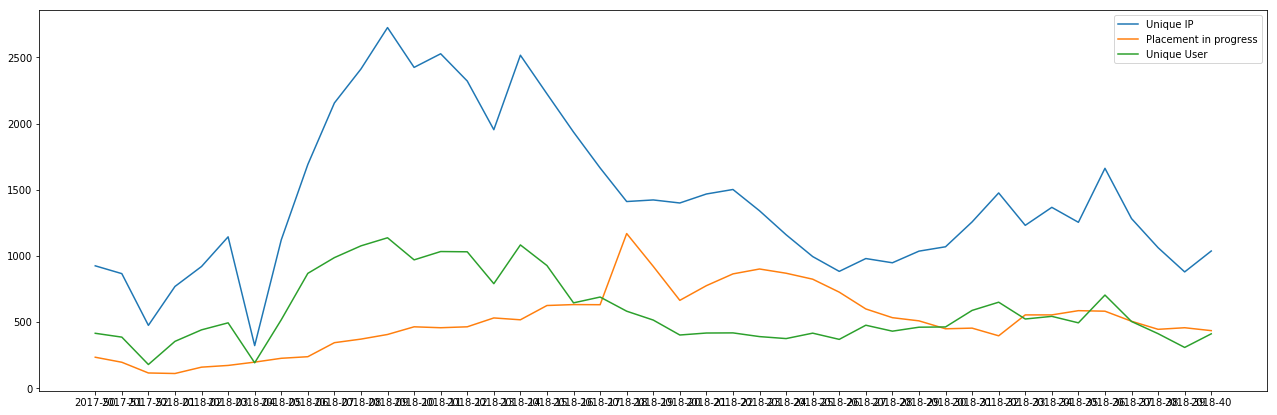

In [140]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 22
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

print ("Current size:",fig_size)

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

The above plot shows what we could also see in the pairplot, the correlation between Unique IP count and Unique User Count, as it was expected

In [141]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'PlacementCount', 'PlacementCompletedCount',
       'PlacementAllocatedInProgressCount', 'PlacementAllocatedCount',
       'PlacementNotAllocatedCount'],
      dtype='object')

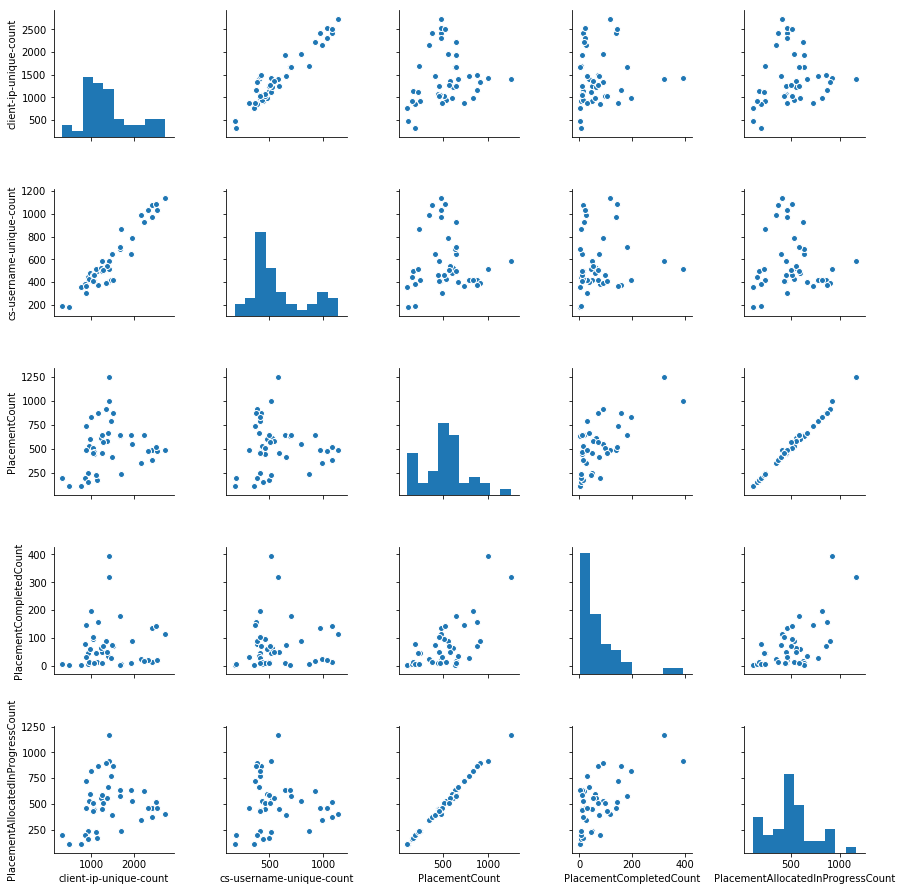

In [142]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

##### Take the Log of unique IP count

In [143]:
log_and_placements_aggregated_per_week_df["client-ip-unique-count-log"] = np.log(log_and_placements_aggregated_per_week_df["client-ip-unique-count"])

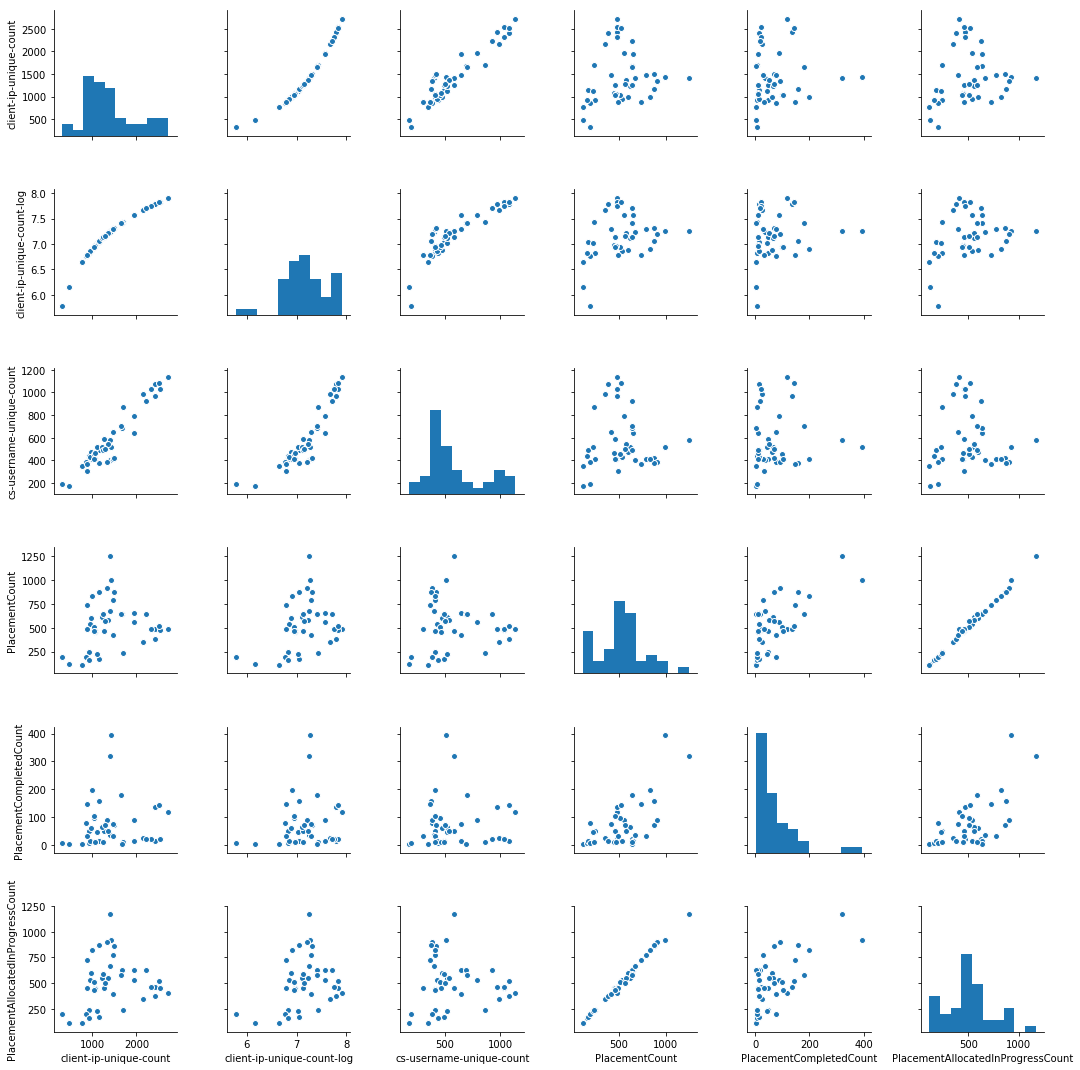

In [144]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','client-ip-unique-count-log','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

#### Autocorrelation

In [145]:
log_and_placements_aggregated_per_week_df.reset_index(inplace=True)
log_and_placements_aggregated_per_week_df.head()

,calendar-year-week,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount,client-ip-unique-count-log
0,2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8,6.829794
1,2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1,6.763885
2,2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0,6.163315
3,2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0,6.645091
4,2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0,6.824374


#### Training Model 1 -- Client-ip-unique-count

In [146]:
df_train = log_and_placements_aggregated_per_week_df.loc[:39,['client-ip-unique-count']]
df_test= log_and_placements_aggregated_per_week_df.loc[40:,['client-ip-unique-count']]

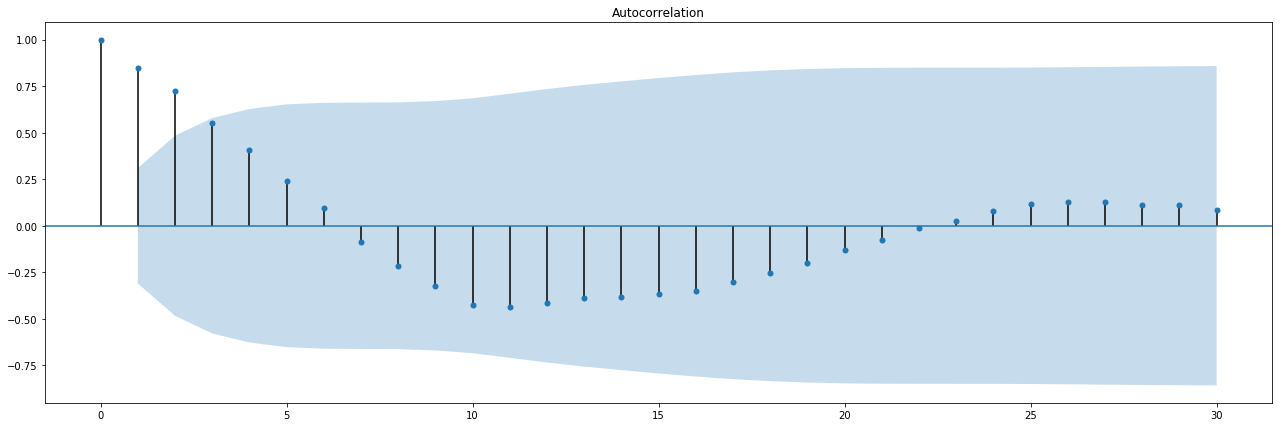

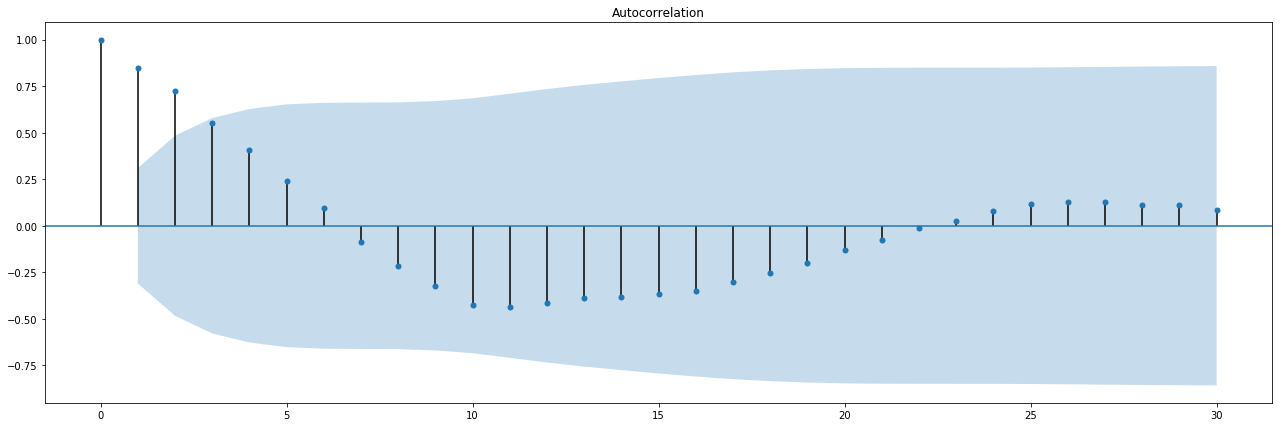

In [147]:
plot_acf(df_train,lags=30)

In [148]:
df_test.tail()


,client-ip-unique-count
40,1062
41,879
42,1037


In [149]:
model = sm.tsa.ARIMA(df_train,(1,0,0)).fit()

predictions = model.predict(40,42,dynamic=True)

predictions

40    1296.814730
41    1309.370824
42    1320.012632
dtype: float64

In [150]:
print("Mean absolute error: ", mean_absolute_error(df_test, predictions))
model.summary()

Mean absolute error:  316.0660620981716


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     client-ip-unique-count   No. Observations:                   40
Model:                         ARMA(1, 0)   Log Likelihood                -285.609
Method:                           css-mle   S.D. of innovations            300.499
Date:                    Wed, 14 Nov 2018   AIC                            577.218
Time:                            19:04:11   BIC                            582.284
Sample:                                 0   HQIC                           579.050
                                                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1379.1720    278.000      4.961      0.000     834.303    1924.041
ar.L1.client-ip-unique-count     0.8475      0.077     11.049      0.000       0.697       0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1799           +0.0000j            1.1799            0.0000
-----------------------------------------------------------------------------
"""

## ARIMA grid search

In [110]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train = X.loc[:39,['client-ip-unique-count']]
    test= X.loc[40:,['client-ip-unique-count']]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    model = sm.tsa.ARIMA(train, order=arima_order).fit()
    predictions = model.predict(40,42,dynamic=True)
    error = mean_absolute_error(test, predictions)
    return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 

# load dataset
p_values = [0, 1, 2, 4,6,8,10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(log_and_placements_aggregated_per_week_df.loc[:,['client-ip-unique-count']], p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=463.458
ARIMA(0, 0, 1) MAE=361.915
ARIMA(0, 0, 2) MAE=349.446
ARIMA(0, 1, 0) MAE=983.513
ARIMA(0, 1, 1) MAE=973.083
ARIMA(0, 1, 2) MAE=972.908
ARIMA(0, 2, 0) MAE=1001.114
ARIMA(0, 2, 1) MAE=880.950
ARIMA(1, 0, 0) MAE=316.066
ARIMA(1, 0, 1) MAE=320.206
ARIMA(1, 0, 2) MAE=342.539
ARIMA(1, 1, 0) MAE=971.403
ARIMA(1, 2, 0) MAE=870.283
ARIMA(1, 2, 1) MAE=880.649
ARIMA(1, 2, 2) MAE=886.008
ARIMA(2, 0, 0) MAE=321.931
ARIMA(2, 0, 1) MAE=482.269
ARIMA(2, 0, 2) MAE=622.980
ARIMA(2, 1, 0) MAE=970.594
ARIMA(2, 1, 2) MAE=946.389
ARIMA(2, 2, 0) MAE=891.864
ARIMA(2, 2, 1) MAE=875.414
ARIMA(2, 2, 2) MAE=886.837
ARIMA(4, 0, 0) MAE=362.405
ARIMA(4, 1, 0) MAE=956.703
ARIMA(4, 1, 1) MAE=953.462
ARIMA(4, 2, 0) MAE=845.026
ARIMA(4, 2, 1) MAE=854.886
ARIMA(4, 2, 2) MAE=879.589
ARIMA(6, 0, 0) MAE=405.519
ARIMA(6, 1, 0) MAE=953.673
ARIMA(6, 1, 1) MAE=953.920
ARIMA(6, 2, 0) MAE=836.046
ARIMA(6, 2, 1) MAE=853.111
ARIMA(6, 2, 2) MAE=847.051
ARIMA(8, 0, 0) MAE=476.395
ARIMA(8, 1, 0) MAE=963.731


#### Training Model 2 -- Client-unique-ip-count-log

In [151]:
df_train_log = log_and_placements_aggregated_per_week_df.loc[:39,['client-ip-unique-count-log']]
df_test_log= log_and_placements_aggregated_per_week_df.loc[40:,['client-ip-unique-count-log']]

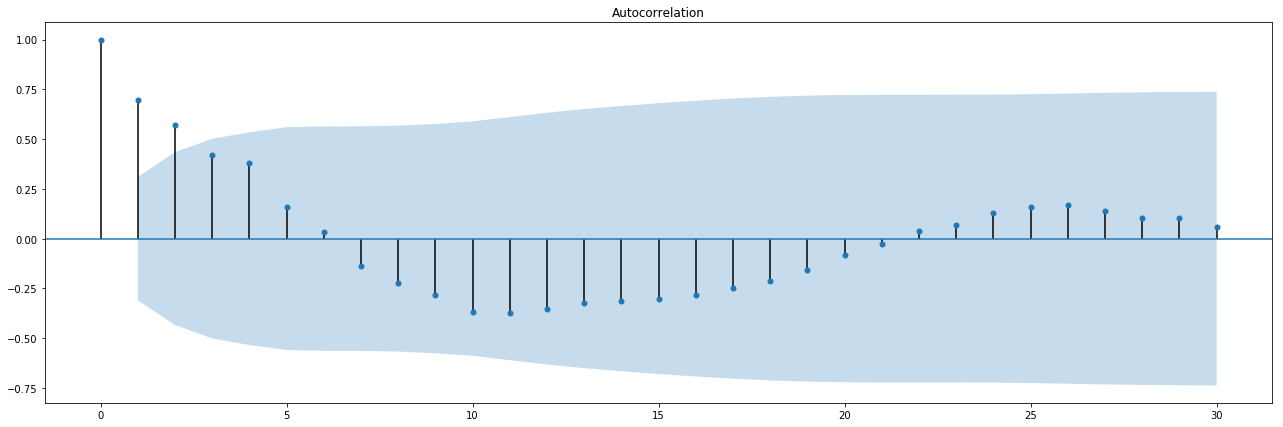

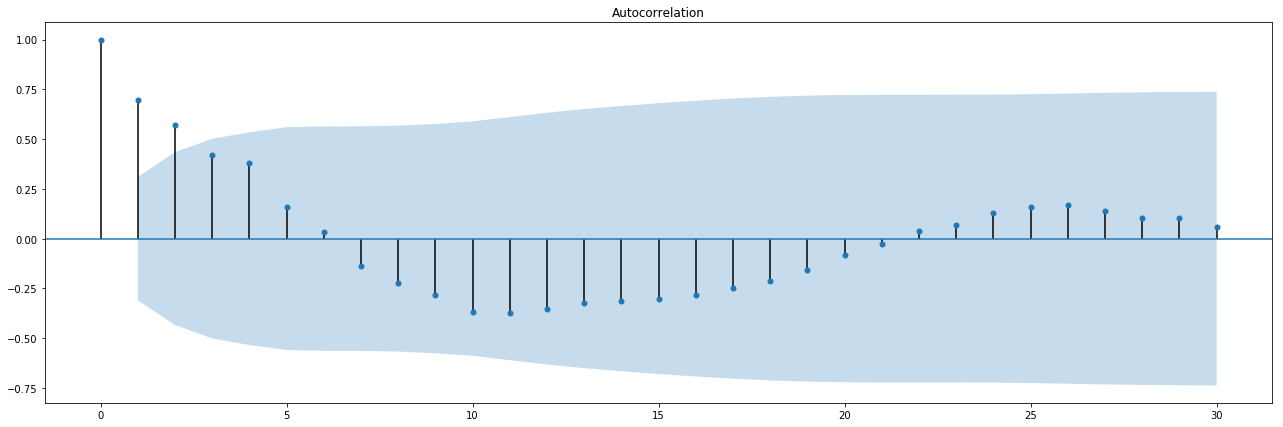

In [152]:
plot_acf(df_train_log,lags=30)

In [153]:
df_test_log.tail()

,client-ip-unique-count-log
40,6.967909
41,6.778785
42,6.944087


In [154]:
model = sm.tsa.ARIMA(df_train_log,(1,0,0)).fit()

predictions = model.predict(40,42,dynamic=True)

predictions

40    7.161897
41    7.165846
42    7.168572
dtype: float64

In [155]:
print("Mean absolute error: ", mean_absolute_error(df_test, predictions))
model.summary()

Mean absolute error:  985.5012285660972


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                  
======================================================================================
Dep. Variable:     client-ip-unique-count-log   No. Observations:                   40
Model:                             ARMA(1, 0)   Log Likelihood                 -10.944
Method:                               css-mle   S.D. of innovations              0.316
Date:                        Wed, 14 Nov 2018   AIC                             27.888
Time:                                19:04:15   BIC                             32.954
Sample:                                     0   HQIC                            29.720
                                                                                      
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                7.1746      0.153     46.857      0.000       6.875       7.475
ar.L1.client-ip-unique-count-log     0.6903      0.110      6.274      0.000       0.475       0.906
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4486           +0.0000j            1.4486            0.0000
-----------------------------------------------------------------------------
"""

## ARIMA Grid Search

In [118]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train = X.loc[:39,['client-ip-unique-count-log']]
    test= X.loc[40:,['client-ip-unique-count-log']]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    model = sm.tsa.ARIMA(train, order=arima_order).fit()
    predictions = model.predict(40,42,dynamic=True)
    error = mean_absolute_error(test, predictions)
    return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 

# load dataset
p_values = [0, 1, 2, 4,6,8,10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(log_and_placements_aggregated_per_week_df.loc[:,['client-ip-unique-count-log']], p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=0.298
ARIMA(0, 0, 1) MAE=0.267
ARIMA(0, 0, 2) MAE=0.265
ARIMA(0, 1, 0) MAE=6.889
ARIMA(0, 1, 1) MAE=6.862
ARIMA(0, 1, 2) MAE=6.862
ARIMA(0, 2, 0) MAE=6.902
ARIMA(0, 2, 1) MAE=6.818
ARIMA(1, 0, 0) MAE=0.269
ARIMA(1, 0, 1) MAE=0.291
ARIMA(1, 0, 2) MAE=0.295
ARIMA(1, 1, 0) MAE=6.865
ARIMA(1, 1, 1) MAE=6.862
ARIMA(1, 2, 0) MAE=6.804
ARIMA(1, 2, 1) MAE=6.815
ARIMA(2, 0, 0) MAE=0.296
ARIMA(2, 0, 1) MAE=0.295
ARIMA(2, 1, 0) MAE=6.864
ARIMA(2, 1, 1) MAE=6.862
ARIMA(2, 1, 2) MAE=6.861
ARIMA(2, 2, 0) MAE=6.825
ARIMA(2, 2, 1) MAE=6.822
ARIMA(4, 0, 0) MAE=0.292
ARIMA(4, 0, 1) MAE=0.297
ARIMA(4, 0, 2) MAE=0.316
ARIMA(4, 1, 0) MAE=6.837
ARIMA(4, 1, 1) MAE=6.838
ARIMA(4, 1, 2) MAE=6.872
ARIMA(4, 2, 0) MAE=6.775
ARIMA(4, 2, 1) MAE=6.783
ARIMA(6, 0, 0) MAE=0.336
ARIMA(6, 0, 1) MAE=0.351
ARIMA(6, 1, 0) MAE=6.836
ARIMA(6, 1, 1) MAE=6.828
ARIMA(6, 1, 2) MAE=6.837
ARIMA(6, 2, 0) MAE=6.780
ARIMA(6, 2, 1) MAE=6.792
ARIMA(6, 2, 2) MAE=6.793
ARIMA(8, 0, 0) MAE=0.375
ARIMA(8, 0, 1) MAE=0.582


In [254]:
np.exp(0.265)

1.3034309757783689

In [255]:
df_test_log

,client-ip-unique-count-log
40,6.967909
41,6.778785
42,6.944087


In [237]:
model = sm.tsa.ARIMA(df_train_log,(0,0,2)).fit()
predictions = model.predict(40,42,dynamic=True)
predictions

40    7.170501
41    7.126363
42    7.187635
dtype: float64

In [257]:
np.exp(6.967909)

1061.9997856864204

In [253]:
np.exp(7.170501)

1300.4959881084253

In [157]:
log_and_placements_aggregated_per_week_df.iloc[40:,1].head()

40    1062
41     879
42    1037
Name: client-ip-unique-count, dtype: int64

#### Log -- Prediction results

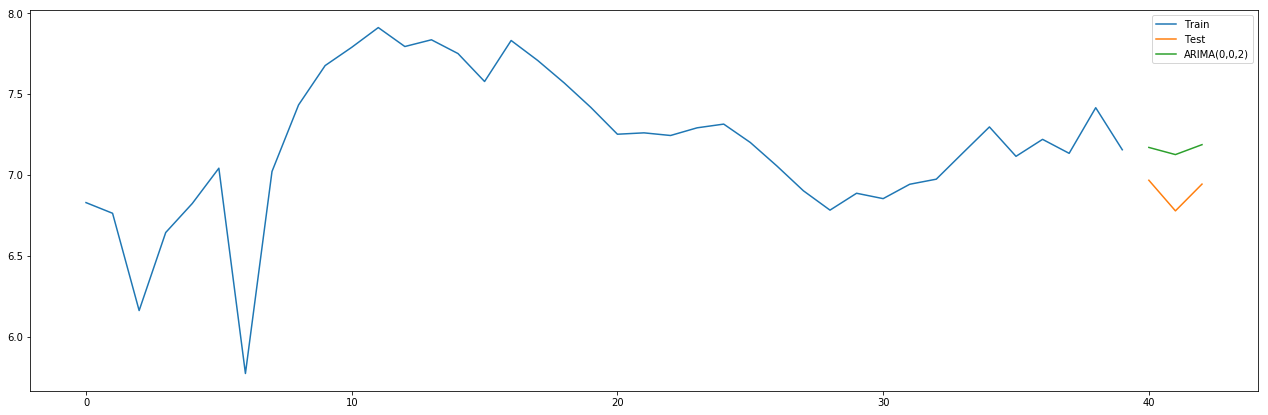

In [235]:
plt.plot(df_train_log.index, df_train_log, label='Train')
plt.plot(df_test_log.index, df_test_log, label='Test')
plt.plot(predictions.index, predictions, label='ARIMA(0,0,2)')
plt.legend(loc='best')

#### Exp -- Prediction results

Applying exp to the train, test and prediction data, to plot actual values, since data used to fit the model had the log applied to the target.

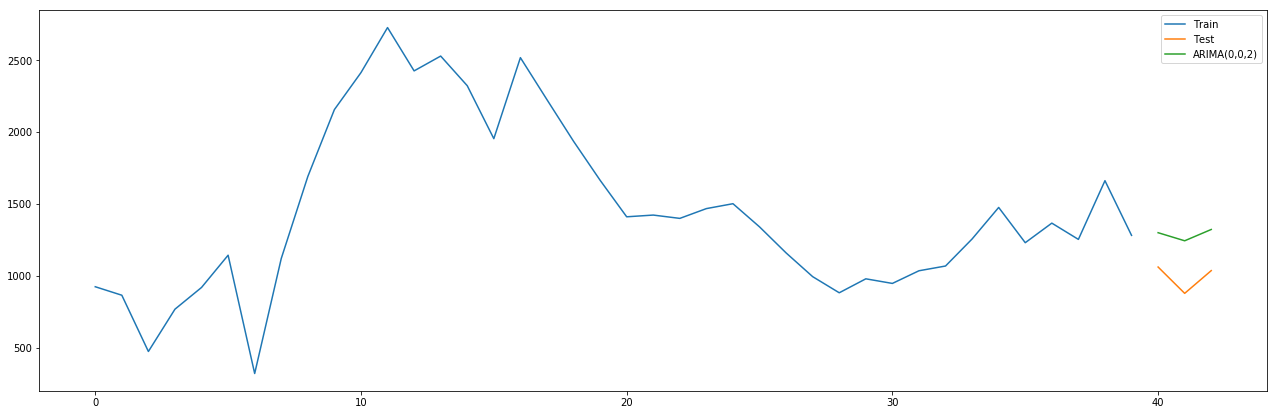

In [236]:
plt.plot(df_train_log.index, np.exp(df_train_log), label='Train')
plt.plot(df_test_log.index, np.exp(df_test_log), label='Test')
plt.plot(predictions.index, np.exp(predictions), label='ARIMA(0,0,2)')
plt.legend(loc='best')

## Holt Winters

Trying out Holt-Winter's model. Interestingly, when spliting train, test data, the model performs bettwer when giving more training data and less test data.

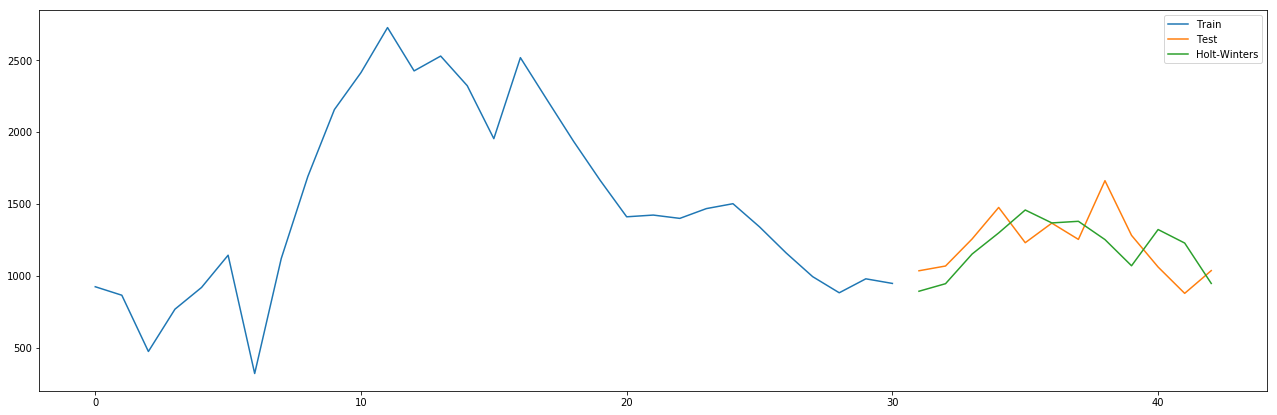

In [244]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#train, test = df.iloc[:130, 0], df.iloc[130:, 0]
train, test = log_and_placements_aggregated_per_week_df.iloc[:31,1], log_and_placements_aggregated_per_week_df.iloc[31:,1]


model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')


In [245]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test, pred))

215.10699952921925

**Try prediction per day**

**facebook prophet**